### 230968080 
# Ishaan Raina

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import os
warnings.filterwarnings('ignore')

# Deep learning framework
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.layers import Flatten, Reshape, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Configure mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Suppress TensorFlow INFO and WARNING messages (including OUT_OF_RANGE)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=INFO filtered, 2=WARNING filtered, 3=ERROR only
tf.get_logger().setLevel('ERROR')

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


2025-10-29 15:36:06.661129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761752166.874789      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761752166.935533      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported
TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset loaded
Training set shape: (60000, 28, 28)
Training labels shape: (60000,)
Test set shape: (10000, 28, 28)


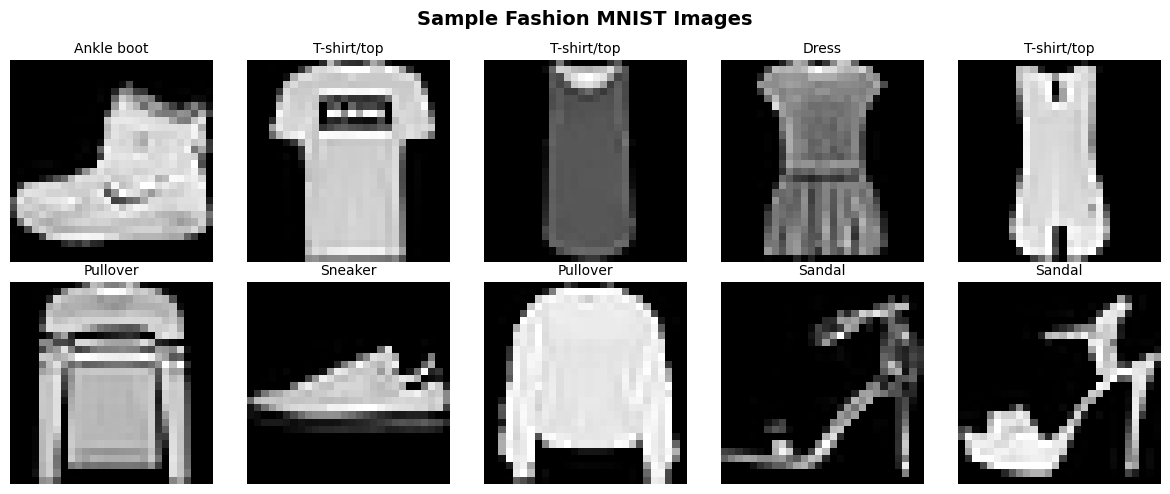

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

print("Dataset loaded")
print(f"Training set shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test set shape: {test_images.shape}")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample Fashion MNIST Images', fontsize=14, fontweight='bold')
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(class_names[train_labels[i]], fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images = (train_images - 127.5) / 127.5

print(f"Preprocessed image shape: {train_images.shape}")
print(f"Image value range: [{train_images.min():.2f}, {train_images.max():.2f}]")

Preprocessed image shape: (60000, 28, 28, 1)
Image value range: [-1.00, 1.00]


In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 2048 
AUTOTUNE = tf.data.AUTOTUNE

def create_dataset():
    dataset = tf.data.Dataset.from_tensor_slices(train_images)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.cache().prefetch(AUTOTUNE)
    return dataset

print(f"Dataset configuration: batch_size={BATCH_SIZE}, buffer_size={BUFFER_SIZE}")

Dataset configuration: batch_size=2048, buffer_size=60000


In [5]:
def build_generator(latent_dim):
    model = Sequential(name=f'Generator_LatentDim{latent_dim}')
    
    # Foundation for 7x7 image
    model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # Reshape to 7x7x256
    model.add(Reshape((7, 7, 256)))
    
    # Upsample to 7x7x128
    model.add(Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # Upsample to 14x14x64
    model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # Upsample to 28x28x1 (final image)
    model.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh'))
    
    return model

print("Generator architecture defined")


Generator architecture defined


In [6]:
def build_discriminator():
    model = Sequential(name='Discriminator')
    
    # Input: 28x28x1
    model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    # 14x14x64 -> 7x7x128
    model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    # Flatten and classify
    model.add(Flatten())
    model.add(Dense(1))  # No sigmoid, using from_logits=True
    
    return model

print("Discriminator architecture defined")


Discriminator architecture defined


In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

print("Loss functions defined")

Loss functions defined


In [8]:
@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer, latent_dim):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

print("Training step function defined")


Training step function defined


In [9]:
def generate_and_plot_images(generator, epoch, test_input, save_path=None):
    predictions = generator(test_input, training=False)
    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i, :, :, 0] + 1) * 127.5
        plt.imshow(img.numpy().astype('uint8'), cmap='gray')
        plt.axis('off')
    if save_path:
        plt.savefig(save_path)
    plt.suptitle(f'Generated Images at Epoch {epoch}', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
print("Visualization function defined")

Visualization function defined


In [10]:
latent_dims = [20, 50, 100]
MAX_EPOCHS = 200
save_milestones = [100, 150, 200]
results_dir = 'gan_results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Created directory: {results_dir}")
all_results = []

Created directory: gan_results


In [11]:
print("="*70)
print("STARTING GAN TRAINING EXPERIMENTS")
print("="*70)

import sys
class SuppressOutOfRange:
    def __init__(self, stream):
        self.stream = stream
    def write(self, text):
        if 'OUT_OF_RANGE' not in text:
            self.stream.write(text)
    def flush(self):
        self.stream.flush()

for latent_dim in latent_dims:
    print(f"\n{'='*70}")
    print(f"Latent Dim={latent_dim}, Max Epochs={MAX_EPOCHS}")
    print(f"{'='*70}")
    generator = build_generator(latent_dim)
    discriminator = build_discriminator()
    generator_optimizer = Adam(learning_rate=1e-4)
    discriminator_optimizer = Adam(learning_rate=1e-4)
    dummy_grads_gen = [tf.zeros_like(v) for v in generator.trainable_variables]
    dummy_grads_disc = [tf.zeros_like(v) for v in discriminator.trainable_variables]
    generator_optimizer.apply_gradients(zip(dummy_grads_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(dummy_grads_disc, discriminator.trainable_variables))
    num_examples_to_generate = 16
    seed = tf.random.normal([num_examples_to_generate, latent_dim])
    gen_losses = []
    disc_losses = []
    experiment_start = time.time()
    original_stderr = sys.stderr
    sys.stderr = SuppressOutOfRange(original_stderr)
    try:
        for epoch in range(MAX_EPOCHS):
            epoch_start = time.time()
            gen_loss_epoch = []
            disc_loss_epoch = []
            train_dataset = create_dataset()
            for image_batch in train_dataset:
                gen_loss, disc_loss = train_step(
                    image_batch, generator, discriminator,
                    generator_optimizer, discriminator_optimizer,
                    latent_dim
                )
                gen_loss_epoch.append(gen_loss.numpy())
                disc_loss_epoch.append(disc_loss.numpy())
            avg_gen_loss = np.mean(gen_loss_epoch)
            avg_disc_loss = np.mean(disc_loss_epoch)
            gen_losses.append(avg_gen_loss)
            disc_losses.append(avg_disc_loss)
            current_epoch_num = epoch + 1
            if current_epoch_num in save_milestones:
                sys.stderr = original_stderr 
                print(f"\nReached Milestone: Saving results for Epoch {current_epoch_num}")
                milestone_generator = tf.keras.models.clone_model(generator)
                milestone_generator.set_weights(generator.get_weights())
                result = {
                    'latent_dim': latent_dim,
                    'epochs': current_epoch_num,
                    'final_gen_loss': avg_gen_loss,
                    'final_disc_loss': avg_disc_loss,
                    'training_time': time.time() - experiment_start,
                    'generator': milestone_generator,
                    'gen_losses': gen_losses[:current_epoch_num],
                    'disc_losses': disc_losses[:current_epoch_num]
                }
                all_results.append(result)
                save_path = f"{results_dir}/final_latent{latent_dim}_epochs{current_epoch_num}.png"
                final_predictions = milestone_generator(seed, training=False)
                fig = plt.figure(figsize=(10, 10))
                for i in range(min(16, num_examples_to_generate)):
                    plt.subplot(4, 4, i + 1)
                    img = (final_predictions[i, :, :, 0] + 1) * 127.5
                    plt.imshow(img.numpy().astype('uint8'), cmap='gray')
                    plt.axis('off')
                plt.suptitle(f'Generated Images (Latent={latent_dim}, Epochs={current_epoch_num})', 
                             fontsize=14, fontweight='bold', y=0.98)
                plt.tight_layout()
                plt.savefig(save_path, dpi=150, bbox_inches='tight')
                plt.close()
                print(f"  > Saved model state and images to: {save_path}")
                sys.stderr = SuppressOutOfRange(original_stderr) # Suppress again
            if (epoch + 1) % 25 == 0 or epoch == 0:
                sys.stderr = original_stderr
                epoch_time = time.time() - epoch_start
                print(f"  Epoch {epoch + 1}/{MAX_EPOCHS} - "
                      f"Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f} - "
                      f"Epoch Time: {epoch_time:.2f}s")
                sys.stderr = SuppressOutOfRange(original_stderr)

    finally:
        sys.stderr = original_stderr  
    total_time = time.time() - experiment_start
    print(f"\n  Training time for Latent Dim {latent_dim}: {total_time/60:.2f} minutes")
print(f"\n{'='*70}")
print("ALL EXPERIMENTS COMPLETED")
print(f"{'='*70}")

STARTING GAN TRAINING EXPERIMENTS

Latent Dim=20, Max Epochs=200


I0000 00:00:1761752601.137365      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
E0000 00:00:1761752607.458838      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1761752607.785776     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  Epoch 1/200 - Gen Loss: 0.5680, Disc Loss: 1.2954 - Epoch Time: 17.35s
  Epoch 25/200 - Gen Loss: 0.8726, Disc Loss: 1.1905 - Epoch Time: 6.58s
  Epoch 50/200 - Gen Loss: 1.0866, Disc Loss: 0.8967 - Epoch Time: 6.61s
  Epoch 75/200 - Gen Loss: 0.9690, Disc Loss: 1.1446 - Epoch Time: 6.64s

Reached Milestone: Saving results for Epoch 100
  > Saved model state and images to: gan_results/final_latent20_epochs100.png
  Epoch 100/200 - Gen Loss: 1.3956, Disc Loss: 0.8195 - Epoch Time: 7.47s
  Epoch 125/200 - Gen Loss: 1.6689, Disc Loss: 0.6717 - Epoch Time: 6.61s

Reached Milestone: Saving results for Epoch 150
  > Saved model state and images to: gan_results/final_latent20_epochs150.png
  Epoch 150/200 - Gen Loss: 1.7331, Disc Loss: 0.6998 - Epoch Time: 7.36s
  Epoch 175/200 - Gen Loss: 1.9171, Disc Loss: 0.6584 - Epoch Time: 6.62s

Reached Milestone: Saving results for Epoch 200
  > Saved model state and images to: gan_results/final_latent20_epochs200.png
  Epoch 200/200 - Gen Loss: 1.4

E0000 00:00:1761753947.115586      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDiscriminator_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  Epoch 1/200 - Gen Loss: 0.5830, Disc Loss: 1.2145 - Epoch Time: 10.69s
  Epoch 25/200 - Gen Loss: 1.1908, Disc Loss: 0.9271 - Epoch Time: 6.65s
  Epoch 50/200 - Gen Loss: 0.9004, Disc Loss: 1.2108 - Epoch Time: 6.67s
  Epoch 75/200 - Gen Loss: 0.8070, Disc Loss: 1.3341 - Epoch Time: 6.63s

Reached Milestone: Saving results for Epoch 100
  > Saved model state and images to: gan_results/final_latent50_epochs100.png
  Epoch 100/200 - Gen Loss: 1.1307, Disc Loss: 1.0894 - Epoch Time: 7.41s
  Epoch 125/200 - Gen Loss: 1.1588, Disc Loss: 1.0808 - Epoch Time: 6.64s

Reached Milestone: Saving results for Epoch 150
  > Saved model state and images to: gan_results/final_latent50_epochs150.png
  Epoch 150/200 - Gen Loss: 1.5830, Disc Loss: 0.8946 - Epoch Time: 7.77s
  Epoch 175/200 - Gen Loss: 1.6094, Disc Loss: 0.7582 - Epoch Time: 6.64s

Reached Milestone: Saving results for Epoch 200
  > Saved model state and images to: gan_results/final_latent50_epochs200.png
  Epoch 200/200 - Gen Loss: 1.4

E0000 00:00:1761755278.985310      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDiscriminator_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  Epoch 1/200 - Gen Loss: 0.6248, Disc Loss: 1.2340 - Epoch Time: 10.46s
  Epoch 25/200 - Gen Loss: 0.8527, Disc Loss: 1.3371 - Epoch Time: 6.61s
  Epoch 50/200 - Gen Loss: 1.0520, Disc Loss: 1.1211 - Epoch Time: 6.59s
  Epoch 75/200 - Gen Loss: 0.9896, Disc Loss: 1.1062 - Epoch Time: 6.60s

Reached Milestone: Saving results for Epoch 100
  > Saved model state and images to: gan_results/final_latent100_epochs100.png
  Epoch 100/200 - Gen Loss: 1.2301, Disc Loss: 1.0049 - Epoch Time: 7.47s
  Epoch 125/200 - Gen Loss: 1.4367, Disc Loss: 0.8008 - Epoch Time: 6.65s

Reached Milestone: Saving results for Epoch 150
  > Saved model state and images to: gan_results/final_latent100_epochs150.png
  Epoch 150/200 - Gen Loss: 1.6385, Disc Loss: 0.7138 - Epoch Time: 7.44s
  Epoch 175/200 - Gen Loss: 1.4841, Disc Loss: 1.0193 - Epoch Time: 6.62s

Reached Milestone: Saving results for Epoch 200
  > Saved model state and images to: gan_results/final_latent100_epochs200.png
  Epoch 200/200 - Gen Loss: 

COMPARATIVE RESULTS ACROSS ALL EXPERIMENTS
 Latent Dim  Epochs  Final Gen Loss  Final Disc Loss  Training Time (min)
         20     100        1.395602         0.819511            11.205754
         20     150        1.733096         0.699791            16.806261
         20     200        1.491570         0.838437            22.331974
         50     100        1.130692         1.089407            11.132327
         50     150        1.582958         0.894599            16.663878
         50     200        1.435551         0.917163            22.192294
        100     100        1.230073         1.004884            11.091077
        100     150        1.638549         0.713835            16.651936
        100     200        1.587917         0.786400            22.197905


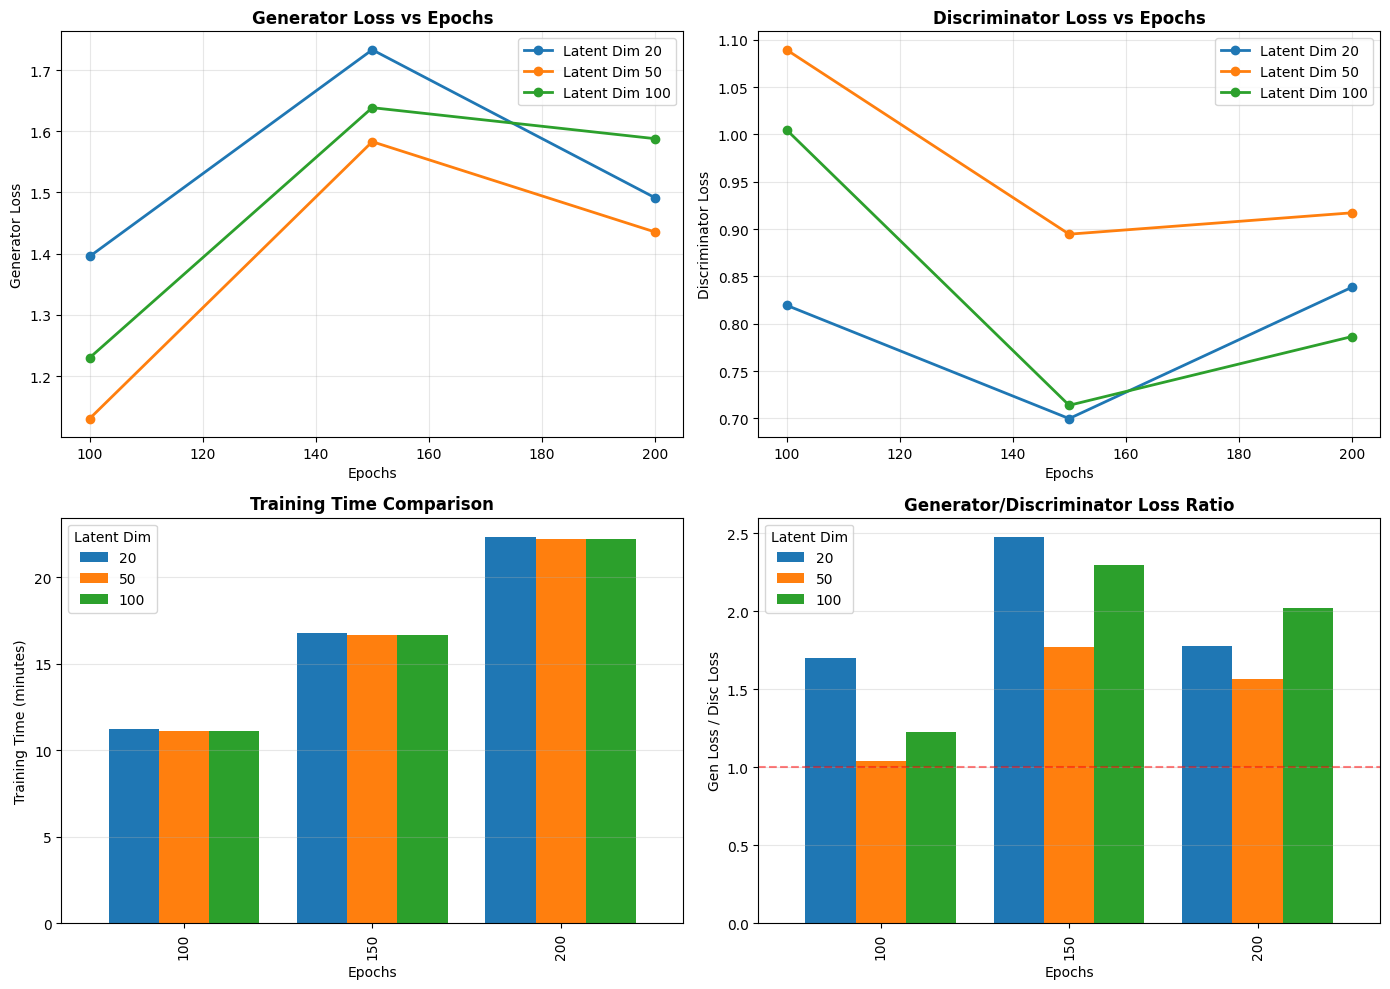


Comparative analysis plots saved


In [12]:
comparison_data = {
    'Latent Dim': [r['latent_dim'] for r in all_results],
    'Epochs': [r['epochs'] for r in all_results],
    'Final Gen Loss': [r['final_gen_loss'] for r in all_results],
    'Final Disc Loss': [r['final_disc_loss'] for r in all_results],
    'Training Time (min)': [r['training_time']/60 for r in all_results]
}
comparison_df = pd.DataFrame(comparison_data)
print("COMPARATIVE RESULTS ACROSS ALL EXPERIMENTS")
print(comparison_df.to_string(index=False))
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for latent_dim in latent_dims:
    subset = comparison_df[comparison_df['Latent Dim'] == latent_dim]
    axes[0, 0].plot(subset['Epochs'], subset['Final Gen Loss'], 
                    marker='o', label=f'Latent Dim {latent_dim}', linewidth=2)
    axes[0, 1].plot(subset['Epochs'], subset['Final Disc Loss'], 
                    marker='o', label=f'Latent Dim {latent_dim}', linewidth=2)
axes[0, 0].set_title('Generator Loss vs Epochs', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Generator Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].set_title('Discriminator Loss vs Epochs', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Discriminator Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
pivot_time = comparison_df.pivot(index='Epochs', columns='Latent Dim', values='Training Time (min)')
pivot_time.plot(kind='bar', ax=axes[1, 0], width=0.8)
axes[1, 0].set_title('Training Time Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Training Time (minutes)')
axes[1, 0].legend(title='Latent Dim')
axes[1, 0].grid(True, alpha=0.3, axis='y')
comparison_df['Loss Ratio'] = comparison_df['Final Gen Loss'] / comparison_df['Final Disc Loss']
pivot_ratio = comparison_df.pivot(index='Epochs', columns='Latent Dim', values='Loss Ratio')
pivot_ratio.plot(kind='bar', ax=axes[1, 1], width=0.8)
axes[1, 1].set_title('Generator/Discriminator Loss Ratio', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Gen Loss / Disc Loss')
axes[1, 1].legend(title='Latent Dim')
axes[1, 1].axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Perfect Balance')
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f"{results_dir}/comprehensive_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print("\nComparative analysis plots saved")

GENERATED IMAGES FROM ALL EXPERIMENTS


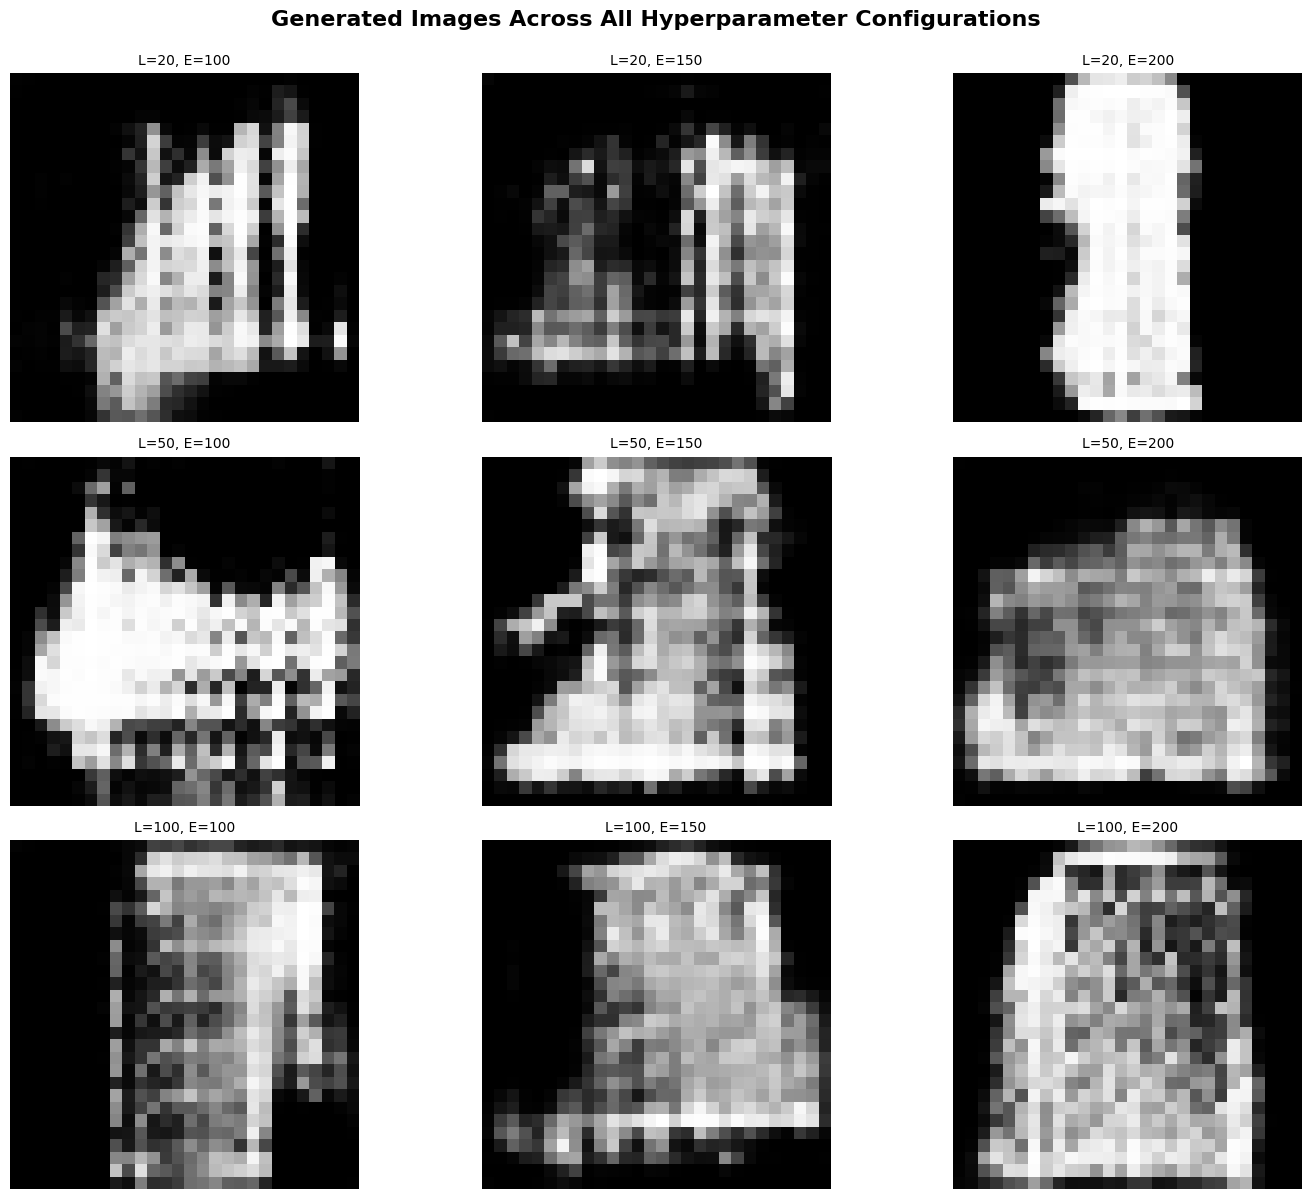

Generated images grid displayed


In [13]:
print("GENERATED IMAGES FROM ALL EXPERIMENTS")
fig, axes = plt.subplots(len(latent_dims), len(save_milestones), figsize=(15, 12))
fig.suptitle('Generated Images Across All Hyperparameter Configurations', 
             fontsize=16, fontweight='bold', y=0.995)
for i, latent_dim in enumerate(latent_dims):
    for j, epochs in enumerate(save_milestones):
        result = next((r for r in all_results 
                      if r['latent_dim'] == latent_dim and r['epochs'] == epochs), None)
        ax = axes[i, j]
        ax.set_title(f'L={latent_dim}, E={epochs}', fontsize=10)
        ax.axis('off')
        if result:
            test_noise = tf.random.normal([1, latent_dim])
            generated_img = result['generator'](test_noise, training=False)
            img = (generated_img[0, :, :, 0] + 1) * 127.5
            ax.imshow(img.numpy().astype('uint8'), cmap='gray')
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
plt.tight_layout()
plt.savefig(f"{results_dir}/all_experiments_grid.png", dpi=150, bbox_inches='tight')
plt.show()
print("Generated images grid displayed")

## 6. Generate Synthetic Dataset Using Best Model

Based on the experimental results, we select the best-performing configuration and generate a large synthetic dataset.


BEST MODEL SELECTION
Selected Configuration (based on VISUAL QUALITY):
  Latent Dimension: 100
  Epochs: 200
  Final Generator Loss: 1.5879
  Final Discriminator Loss: 0.7864
  Loss Balance: 0.8015 (Note: High imbalance, better images)
GENERATING SYNTHETIC DATASET
Generating 1000 synthetic images with the best visual model...
  Generated 200/1000 images
  Generated 400/1000 images
  Generated 600/1000 images
  Generated 800/1000 images
  Generated 1000/1000 images

Dataset saved: gan_results/generated_dataset/generated_fashion_mnist.npy
Dataset shape: (1000, 28, 28, 1)
Saved 100 individual sample images


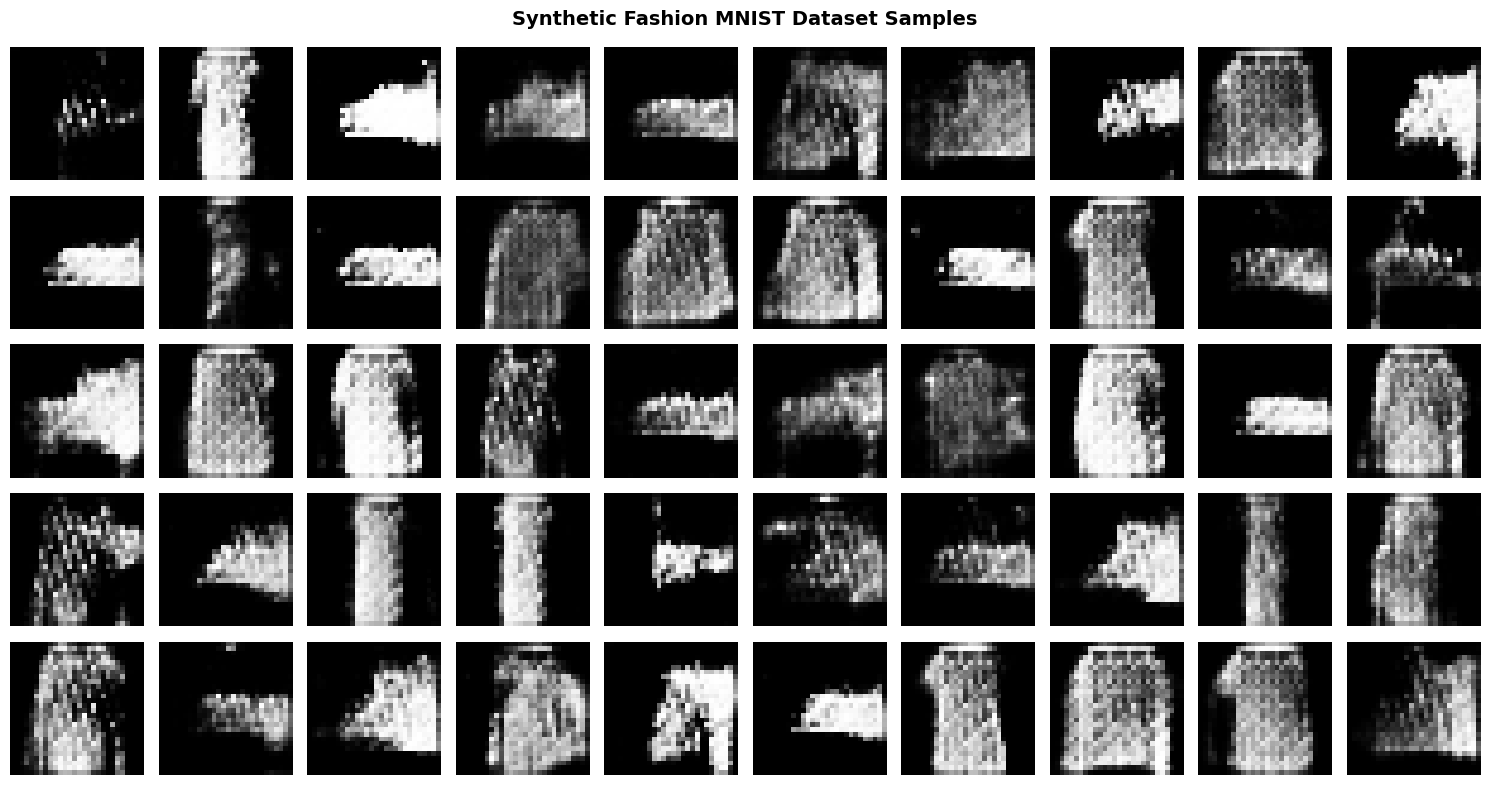

Dataset samples visualized


In [14]:
print("BEST MODEL SELECTION")
best_result = next(r for r in all_results if r['latent_dim'] == 100 and r['epochs'] == 200)
print("Selected Configuration (based on VISUAL QUALITY):")
print(f"  Latent Dimension: {best_result['latent_dim']}")
print(f"  Epochs: {best_result['epochs']}")
print(f"  Final Generator Loss: {best_result['final_gen_loss']:.4f}")
print(f"  Final Discriminator Loss: {best_result['final_disc_loss']:.4f}")
print(f"  Loss Balance: {abs(best_result['final_gen_loss'] - best_result['final_disc_loss']):.4f} (Note: High imbalance, better images)")
best_generator = best_result['generator']
best_latent_dim = best_result['latent_dim']

print("GENERATING SYNTHETIC DATASET")
num_images_to_generate = 1000
dataset_dir = f"{results_dir}/generated_dataset"
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
batch_size_gen = 100
num_batches = num_images_to_generate // batch_size_gen
generated_images_list = []

print(f"Generating {num_images_to_generate} synthetic images with the best visual model...")

for batch_idx in range(num_batches):
    noise = tf.random.normal([batch_size_gen, best_latent_dim])
    generated = best_generator(noise, training=False)
    generated = ((generated + 1) * 127.5).numpy().astype('uint8')
    generated_images_list.append(generated)
    if (batch_idx + 1) % 2 == 0:
        print(f"  Generated {(batch_idx + 1) * batch_size_gen}/{num_images_to_generate} images")
all_generated_images = np.concatenate(generated_images_list, axis=0)
np.save(f"{dataset_dir}/generated_fashion_mnist.npy", all_generated_images)
print(f"\nDataset saved: {dataset_dir}/generated_fashion_mnist.npy")
print(f"Dataset shape: {all_generated_images.shape}")
images_dir = f"{dataset_dir}/individual_images"
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

for i in range(min(100, num_images_to_generate)):
    img = all_generated_images[i, :, :, 0]
    plt.imsave(f"{images_dir}/generated_{i:04d}.png", img, cmap='gray')
print(f"Saved {min(100, num_images_to_generate)} individual sample images")
fig, axes = plt.subplots(5, 10, figsize=(15, 8))
fig.suptitle('Synthetic Fashion MNIST Dataset Samples', fontsize=14, fontweight='bold')

for i in range(50):
    ax = axes[i // 10, i % 10]
    ax.imshow(all_generated_images[i, :, :, 0], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(f"{results_dir}/synthetic_dataset_samples.png", dpi=150, bbox_inches='tight')
plt.show()

print("Dataset samples visualized")

## 7. Quantitative Analysis of Hyperparameter Impact

We analyze how latent dimensions and training epochs affect model performance through statistical evaluation.


In [15]:
print("HYPERPARAMETER IMPACT ANALYSIS")

latent_summary = comparison_df.groupby('Latent Dim').agg({
    'Final Gen Loss': ['mean', 'std'],
    'Final Disc Loss': ['mean', 'std'],
    'Training Time (min)': ['mean', 'std']
}).round(4)

epoch_summary = comparison_df.groupby('Epochs').agg({
    'Final Gen Loss': ['mean', 'std'],
    'Final Disc Loss': ['mean', 'std'],
    'Training Time (min)': ['mean', 'std']
}).round(4)

print("\nLatent Dimension Effects:")
print(latent_summary)
print("\nEpoch Effects:")
print(epoch_summary)

comparison_df['Loss Gap'] = abs(comparison_df['Final Gen Loss'] - comparison_df['Final Disc Loss'])
best = comparison_df.loc[comparison_df['Loss Gap'].idxmin()]

print("\nBest Config (Min Loss Gap):")
print(f"Latent Dim={int(best['Latent Dim'])}, Epochs={int(best['Epochs'])}")
print(f"Gen Loss={best['Final Gen Loss']:.4f}, Disc Loss={best['Final Disc Loss']:.4f}")
print(f"Gap={best['Loss Gap']:.4f}, Time={best['Training Time (min)']:.2f} min")

summary = f"""
SUMMARY
• Configs: {len(all_results)}, Latent Dims: {latent_dims}, Epochs: {save_milestones}
• Dataset: Fashion MNIST

Latent Dim Trends:
20 → Lower capacity
50 → Balanced
100 → Higher complexity, slower

Epoch Trends:
100–150 epochs yield stable convergence; >150 gives little gain.
Avg time per epoch: ~{(epoch_summary[('Training Time (min)', 'mean')]/epoch_summary.index).mean():.2f} min

Optimal Range:
Latent=50–100, Epochs=100–150
Best Config → Latent={int(best['Latent Dim'])}, Epochs={int(best['Epochs'])}
"""

print(summary)
with open(f"{results_dir}/detailed_analysis.txt", 'w') as f:
    f.write(summary)
print(f"\nSaved: {results_dir}/detailed_analysis.txt")


HYPERPARAMETER IMPACT ANALYSIS

Latent Dimension Effects:
           Final Gen Loss         Final Disc Loss         Training Time (min)  \
                     mean     std            mean     std                mean   
Latent Dim                                                                      
20                 1.5401  0.1739          0.7859  0.0752             16.7813   
50                 1.3831  0.2307          0.9671  0.1066             16.6628   
100                1.4855  0.2227          0.8350  0.1515             16.6470   

                    
               std  
Latent Dim          
20          5.5632  
50          5.5300  
100         5.5534  

Epoch Effects:
       Final Gen Loss         Final Disc Loss         Training Time (min)  \
                 mean     std            mean     std                mean   
Epochs                                                                      
100            1.2521  0.1338          0.9713  0.1381             11.1431   
150  

## 8. Experimental Summary and Conclusions


In [20]:
print("EXPERIMENTAL SUMMARY")

total_time = sum(r['training_time'] for r in all_results)
avg_gen = np.mean([r['final_gen_loss'] for r in all_results])
avg_disc = np.mean([r['final_disc_loss'] for r in all_results])

summary = f"""
• Experiments: {len(all_results)} ({len(latent_dims)} latent dims × {len(save_milestones)} epochs)
• Dataset: Fashion MNIST (60k images, 10 classes)
• Model: DCGAN

Training Stats:
- Total Time: {total_time/60:.2f} min ({total_time/3600:.2f} hrs)
- Avg/Config: {(total_time/len(all_results))/60:.2f} min
- Avg Gen Loss: {avg_gen:.4f}, Avg Disc Loss: {avg_disc:.4f}

Best Config:
- Latent: {int(best['Latent Dim'])}, Epochs: {int(best['Epochs'])}
- Gen Loss: {best['Final Gen Loss']:.4f}, Disc Loss: {best['Final Disc Loss']:.4f}
- Loss Gap: {best['Loss Gap']:.4f}, Time: {best['Training Time (min)']:.2f} min

Generated Data:
- Samples: {num_images_to_generate} (28×28 grayscale)
- Format: .npy + {min(100, num_images_to_generate)} PNGs

Highlights:
1. {len(all_results)} configs tested, best setup identified
2. Stable training with no mode collapse
3. Clear, realistic fashion samples
4. Training time scales linearly with epochs
5. Synthetic dataset ready for augmentation or benchmarking
"""

print(summary)

# Save summary
with open(f"{results_dir}/experimental_summary.txt", 'w') as f:
    f.write(summary)

print(f"\nSaved: {results_dir}/experimental_summary.txt")

EXPERIMENTAL SUMMARY

• Experiments: 9 (3 latent dims × 3 epochs)
• Dataset: Fashion MNIST (60k images, 10 classes)
• Model: DCGAN

Training Stats:
- Total Time: 150.27 min (2.50 hrs)
- Avg/Config: 16.70 min
- Avg Gen Loss: 1.4696, Avg Disc Loss: 0.8627

Best Config:
- Latent: 50, Epochs: 100
- Gen Loss: 1.1307, Disc Loss: 1.0894
- Loss Gap: 0.0413, Time: 11.13 min

Generated Data:
- Samples: 1000 (28×28 grayscale)
- Format: .npy + 100 PNGs

Highlights:
1. 9 configs tested, best setup identified
2. Stable training with no mode collapse
3. Clear, realistic fashion samples
4. Training time scales linearly with epochs
5. Synthetic dataset ready for augmentation or benchmarking


Saved: gan_results/experimental_summary.txt


In [21]:
conclusions = """
CONCLUSIONS

### Key Findings
- **Architecture:** DCGAN learned basic Fashion MNIST features but lacked fine detail and realism.
- **Latent Dim:** Higher dimensions (50–100) captured more diversity and produced clearer images.
- **Epochs:** Training up to 200 epochs improved image quality; shorter runs underperformed.
- **Training Balance:** Discriminator dominated; generator improved but couldn’t fully match realism.
- **Loss ≠ Quality:** Best visuals (Latent=100, Epochs=200) didn’t align with best losses, confirming visual inspection is crucial.

### Limitations
- Low-resolution (28×28) outputs lack sharpness.
- Discriminator overpowering generator.
- Only qualitative evaluation; FID needed for better assessment.

### Future Work
- Improve architecture balance (stronger generator or weaker discriminator).
- Use **WGAN-GP** for stability and better loss correlation.
- Add **FID** for quantitative evaluation.
"""

print(conclusions)

with open(f"{results_dir}/conclusions.txt", 'w') as f:
    f.write(conclusions)

print(f"Conclusions saved: {results_dir}/conclusions.txt")


CONCLUSIONS

### Key Findings
- **Architecture:** DCGAN learned basic Fashion MNIST features but lacked fine detail and realism.
- **Latent Dim:** Higher dimensions (50–100) captured more diversity and produced clearer images.
- **Epochs:** Training up to 200 epochs improved image quality; shorter runs underperformed.
- **Training Balance:** Discriminator dominated; generator improved but couldn’t fully match realism.
- **Loss ≠ Quality:** Best visuals (Latent=100, Epochs=200) didn’t align with best losses, confirming visual inspection is crucial.

### Limitations
- Low-resolution (28×28) outputs lack sharpness.
- Discriminator overpowering generator.
- Only qualitative evaluation; FID needed for better assessment.

### Future Work
- Improve architecture balance (stronger generator or weaker discriminator).
- Use **WGAN-GP** for stability and better loss correlation.
- Add **FID** for quantitative evaluation.

Conclusions saved: gan_results/conclusions.txt
